# Amazon Product Review Feature Engineering Notebook

The purpose of this notebook is to perform some feature engineering on the Amazon Product Review Data. The overall scope of this project is to determine if product reviews on Amazon.com have any sort of impact on the overall sales ranking of any particular item. The data was obtain with permission from the following paper:

Justifying recommendations using distantly-labeled reviews and fined-grained aspects
Jianmo Ni, Jiacheng Li, Julian McAuley
Empirical Methods in Natural Language Processing (EMNLP), 2019

In [ ]:
#First import some packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


In [2]:
#First load the data

rev = pd.read_csv('Data/ProcessedAmazonReviewData60k.csv', index_col=False)
rev.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,category,...,brand,rank,main_cat,price,rankCat,parent,catRank,Ranking,salesRanking,ratingPrice
0,5.0,True,"08 22, 2013",A1ZVYSRTRT9QK6,B0012AL2B8,Tall teacher,"Sturdy, nicely finished, easily assembled and ...",Just what I expected,1377129600,"['Home & Kitchen', 'Furniture', 'Home Office F...",...,Winsome Wood,"['>#94,539 in Home & Kitchen (See top 100)', '...",Amazon Home,8.43,"[""94,539 in Home & Kitchen (See top 100)', '"",...",B0012AL2B8,195 in Home & Kitchen > Storage & Organization...,195.0,993.0,42.15
1,5.0,True,"05 19, 2016",A3I9ESA9V9KEVA,B00QGD3SBI,TjU,They fit and they're cheap. What more do you ...,What more do you want?,1463616000,"['Home & Kitchen', 'Vacuums & Floor Care', 'Va...",...,EnviroCare,"['>#15,763 in Home & Kitchen (See Top 100 in H...",Amazon Home,6.96,"[""15,763 in Home & Kitchen (See Top 100 in Hom...",B00631W4TU,36 in Home & Kitchen > Vacuums & Floor Care > ...,36.0,1152.0,34.80
2,5.0,True,"09 1, 2015",AW5T6CTQERFQZ,B001L5U2DS,GA,Great product,Stylish and useful,1441065600,"['Home & Kitchen', 'Storage & Organization', '...",...,Command,"['>#3,455 in Tools & Home Improvement (See top...",Tools & Home Improvement,8.41,"[""3,455 in Tools & Home Improvement (See top 1...",B001L5U2DS,59 in Home & Kitchen > Storage & Organization ...,59.0,1129.0,42.05
3,5.0,False,"04 29, 2017",AVICOGDMRU0Q8,B00KZ64UNC,Robert Diller,"Nice juicer, loved it the first time I used it.",Five Stars,1493424000,"['Home & Kitchen', 'Kitchen & Dining', 'Kitche...",...,Innovee Home,"['>#31,804 in Kitchen & Dining (See Top 100 in...",Amazon Home,14.95,"[""31,804 in Kitchen & Dining (See Top 100 in K...",B00KZ64UNC,64 in Kitchen & Dining > Kitchen Utensils & Ga...,64.0,1124.0,74.75
4,5.0,True,"11 12, 2015",A1WFG0ZNBWKVOD,B00JUED8V0,Stephanie Burke,after a while the plastic cups become scratche...,Glad I found,1447286400,"['Home & Kitchen', 'Kitchen & Dining', 'Small ...",...,NutriBullet,['>#513 in Kitchen & Dining (See Top 100 in Ki...,Amazon Home,15.80,"[""513 in Kitchen & Dining (See Top 100 in Kitc...",B00JUED8V0,1 in Home & Kitchen > Kitchen & Dining > Small...,1.0,1187.0,79.00


The first feature to add to the data set will be the average rating for each product. However, due to the volume of items available on the Amazon marketplace, I suspect there will be quite a few items that will only have one review. We'll take a look at the number of unique items and the overall number of items. 

In [3]:
print('The number of duplicate reviews is:', rev.shape[0]-len(rev['asin'].unique()))
print('The number of unique items reviewed is:', len(rev.asin.unique()))

The number of duplicate reviews is: 20865
The number of unique items reviewed is: 19142


It appears about half of the products have been reviewed more than once, but that shouldn't be an issue for this review. I'll calculate the average rating as well as the count of the reviews. 

In [4]:
rev['AvgRating'] = rev['overall'].groupby(rev.asin).transform('mean')
rev['RatingCount'] = rev['overall'].groupby(rev.asin).transform('sum')

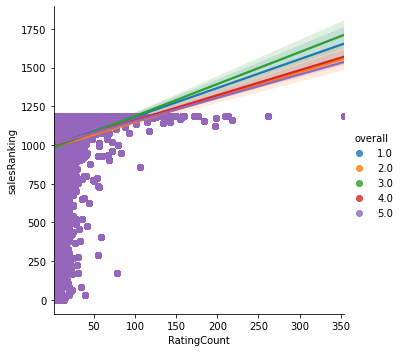

In [5]:
sns.lmplot(x = 'RatingCount', y = 'salesRanking', data = rev, hue = 'overall')


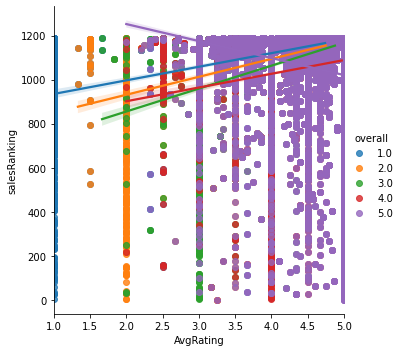

In [6]:
sns.lmplot(x='AvgRating', y = 'salesRanking', data = rev, hue = 'overall')

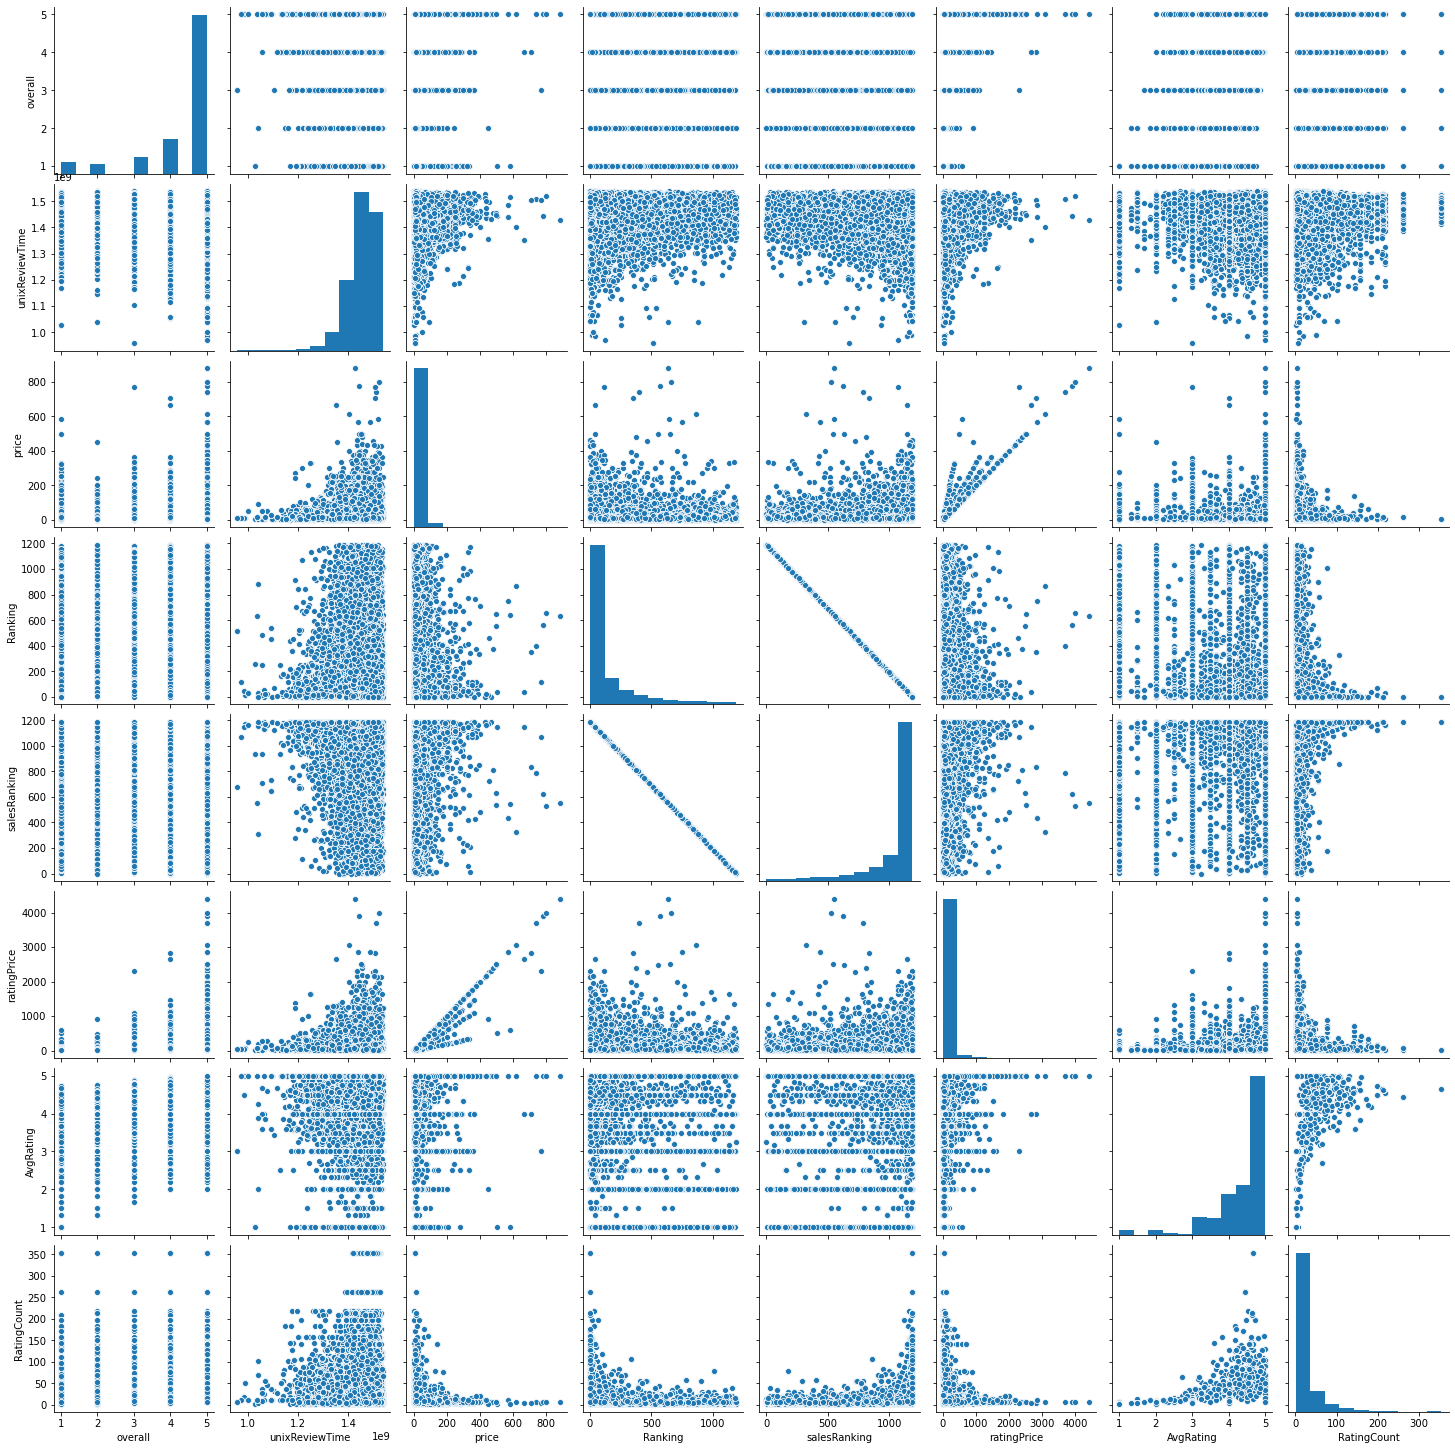

In [7]:
sns.pairplot(rev.drop('verified', axis = 1))

Next I want to create a continuous variable to reflect the sentiment of the review. 
This function will utilize the VADER sentiment analyzer and will average the sentiment of all sentances
in the review. The final variable will be the average of the compound score reported by VADER.

In [8]:
#First I need to import the subjectivity and VADER packages from nltk
import nltk
from nltk.corpus import subjectivity
from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#The function creates an instance of the sentiment analyzer and tokenizes the review into sentances. 
#the sentiment of each sentance is stored in a list and the mean of the compound score is taken and returned. 
#If the review contains no text, then 0 is returned (equivalent of a neutral review)
def getSentiment(review):
    if len(review) == 0:
        return 0
    sid = SentimentIntensityAnalyzer()
    sentiment = []
    for sentance in tokenize.sent_tokenize(review):
        ss = sid.polarity_scores(sentance)
        sentiment.append(ss['compound'])
    return np.mean(sentiment)

In [9]:
#Now apply the function to the dataframe and store the results in a new column. 
rev['reviewSentiment'] = rev['reviewText'].apply(getSentiment)

In [10]:
#Next I want to create a variable to capture the length of the review to determine if the length has any impact on the Ranking. 

#Create a regex tokenizer to drop punctuation
tokenizer = nltk.RegexpTokenizer(r"\w+")
#Now apply the tokenizer to each review and count the lenth
rev['reviewLength'] = rev['reviewText'].apply(lambda x: len(tokenizer.tokenize(x)) if len(x) > 0 else 0)

<AxesSubplot:>

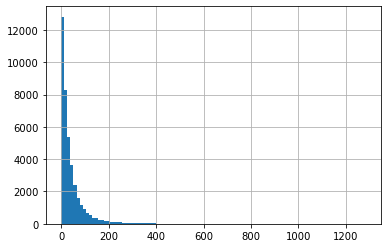

In [11]:
#Lets have a look at the results:
rev['reviewLength'].hist(bins=100)

I'm curious to see if there are any hidden patterns in the data that I can use as a predictor variable. I'll use the KMeans clustering algorithm from sklearn to engineer some clusters. The first step will be to determine the number of clusters to use. I'll accomplish this using the elbow plot method. First I need to create an X vector for the KMeans algorithm. Then I'll test the variance explained by 1 to 50 clusters. Once we have the clusters we can append them to the data and look for interaction terms.

In [12]:
#First I need to prepare the data for the KMeans algorithm. I'll start by dropping categorical columns. 
#I also need to split the data into train and test groups. 

x_train, x_test, y_train, y_test = train_test_split(rev.drop(['salesRanking'], axis=1), rev.salesRanking, )

obs = []
[obs.append(col) for col in x_train.columns if rev[col].dtype == 'O']
xClf = x_train.drop(obs, axis = 1)

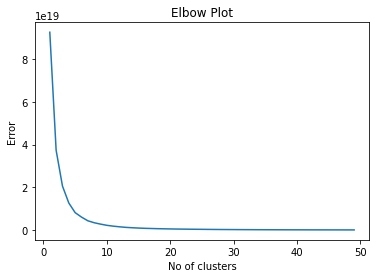

In [13]:
#Run through the number of clusters ranging form 1 to 50. 

from sklearn.cluster import KMeans
Error = []
for i in range(1, 50):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(xClf)
    Error.append(kmeans.inertia_)
plt.plot(range(1, 50), Error)
plt.title('Elbow Plot')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

In [14]:
#I'll plan to use 8 clusters. Now I need to generate the features and append them to the dataframe. 
kmeans = KMeans(n_clusters = 8)
kmeans.fit(xClf)
clusters = kmeans.predict(xClf)
x_train['clusters'] = clusters

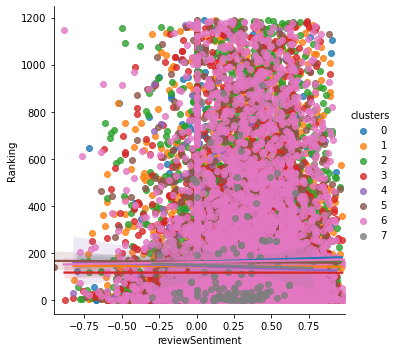

In [15]:
#Looks good. 
sns.lmplot(x='reviewSentiment', y = 'Ranking', data = x_train, hue = 'clusters')

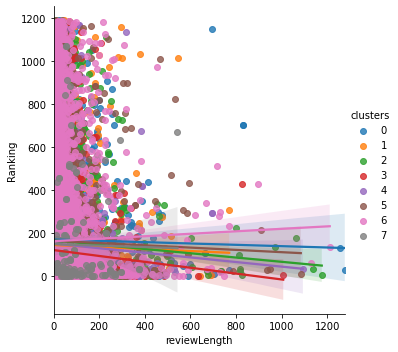

In [16]:
sns.lmplot(x='reviewLength', y = 'Ranking', data = x_train, hue = 'clusters')
#It looks like the ranking decreases as the reviews become increasingly verbose. 

In [17]:
#I'll go ahead and create an interaction term for cluster_reviewLength
x_train['clusterXreviewLength'] = x_train['clusters']*x_train['reviewLength']

Text(0.5, 1.0, 'Ranking vs Price varying by cluster')

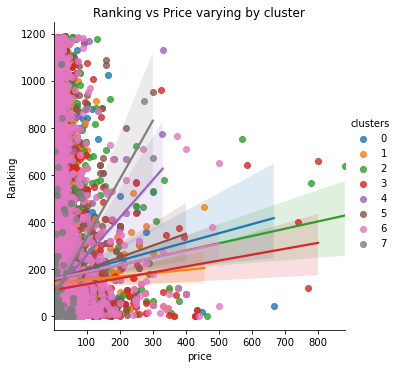

In [18]:
#Now I'll look for interaction terms using the clusters. 
#If the slopes or intercepts vary by cluster for ranking vs the other continuous variables then there are likely interactions
sns.lmplot(x = 'price', y = 'Ranking', hue = 'clusters', data = x_train)
plt.title('Ranking vs Price varying by cluster')

In [19]:
#There may also be an interaction between price and cluster. I'll create an interaction term there as well.
x_train['clusterXprice'] = x_train['clusters']*x_train['price']

Text(0.5, 1.0, 'Ranking vs overall rating varying by cluster')

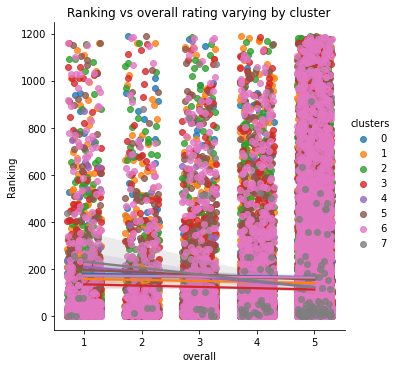

In [20]:
sns.lmplot(x = 'overall', y = 'Ranking', hue = 'clusters', data = x_train, x_jitter = 0.3)
plt.title('Ranking vs overall rating varying by cluster')

In [21]:
#There may also be an interaction between cluster and overall
x_train['clusterXprice'] = x_train['clusters']*x_train['price']

Text(0.5, 1.0, 'Ranking vs AvgRating varying by cluster')

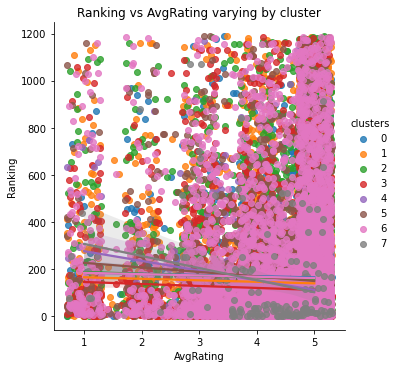

In [22]:
sns.lmplot(x = 'AvgRating', y = 'Ranking', hue = 'clusters', data = x_train, x_jitter = 0.3)
plt.title('Ranking vs AvgRating varying by cluster')

In [23]:
#Create an interaction term between cluster and average rating
x_train['clusterXavgRating'] = x_train['clusters']*x_train['AvgRating']

Text(0.5, 1.0, 'Ranking vs RatingCount varying by cluster')

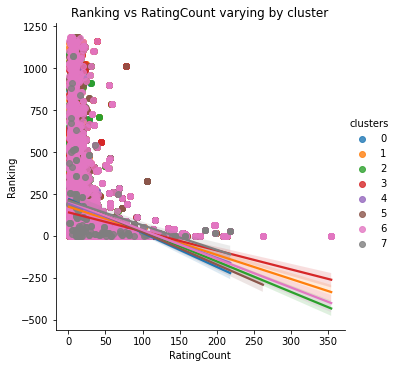

In [24]:
sns.lmplot(x = 'RatingCount', y = 'Ranking', hue = 'clusters', data = x_train, x_jitter = 0.3)
plt.title('Ranking vs RatingCount varying by cluster')

In [25]:
#Create an interaction between RatingCount and clusters
x_train['clusterXratingCount'] = x_train['clusters']*x_train['RatingCount']

<AxesSubplot:>

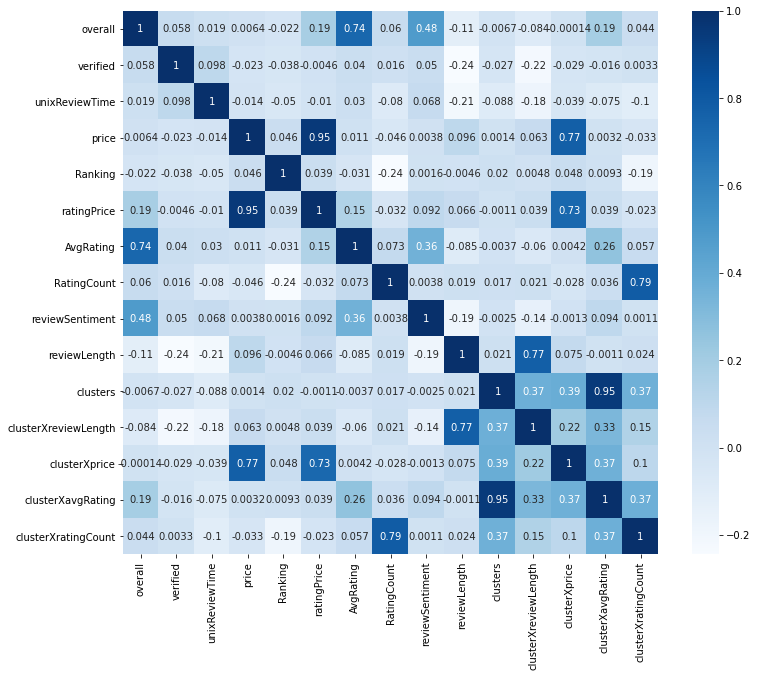

In [26]:
plt.figure(figsize = (12,10))
sns.heatmap(x_train.corr(), annot = True, cmap = 'Blues')
